In [ ]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/anastasia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Скачиваем данные

In [ ]:
!wget https://github.com/BobaZooba/HSE-Deep-Learning-in-NLP-Course/blob/master/week_05/data/answers_subsample.csv?raw=true -O data.csv

In [2]:
# если ругается на то, что нет wget
# !apt-get install wget

In [3]:
!ls -l

total 4621056
-rw-r--r-- 1 anastasia anastasia      99282 окт 22 23:53  0.84_test.ipynb
-rw-r--r-- 1 anastasia anastasia      70308 окт 20 21:56 'Attention from scratch.ipynb'
-rw-r--r-- 1 anastasia anastasia 4536408847 окт 20 23:15  cc.ru.300.vec
-rw-r--r-- 1 anastasia anastasia     100460 окт 23 00:36 'Classification Subsample Mail.ipynb'
drwxr-xr-x 2 anastasia anastasia       4096 окт 20 20:01  data
-rw-r--r-- 1 anastasia anastasia   28717126 окт 20 23:34  data.csv
-rw-r--r-- 1 anastasia anastasia  155306374 окт 23 00:29  model.pt
-rw-r--r-- 1 anastasia anastasia   11227212 окт 20 20:01  Transformer.pdf
-rw-r--r-- 1 anastasia anastasia       1216 окт 20 21:06  Untitled.ipynb


In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('data.csv')

In [6]:
data

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон
...,...,...
237774,relax,елку нарядили? =)
237775,law,"Имеется переработка при 75% ставки, отгулы не ..."
237776,food,Попробовала варить рис с половиной кубика для ...
237777,food,Почему рекоменд... Почему рекомендуют есть фру...


In [7]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [8]:
!wget -O- https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz | gunzip > cc.ru.300.vec

In [9]:
!ls -l

total 4621056
-rw-r--r-- 1 anastasia anastasia      99282 окт 22 23:53  0.84_test.ipynb
-rw-r--r-- 1 anastasia anastasia      70308 окт 20 21:56 'Attention from scratch.ipynb'
-rw-r--r-- 1 anastasia anastasia 4536408847 окт 20 23:15  cc.ru.300.vec
-rw-r--r-- 1 anastasia anastasia     100460 окт 23 00:36 'Classification Subsample Mail.ipynb'
drwxr-xr-x 2 anastasia anastasia       4096 окт 20 20:01  data
-rw-r--r-- 1 anastasia anastasia   28717126 окт 20 23:34  data.csv
-rw-r--r-- 1 anastasia anastasia  155306374 окт 23 00:29  model.pt
-rw-r--r-- 1 anastasia anastasia   11227212 окт 20 20:01  Transformer.pdf
-rw-r--r-- 1 anastasia anastasia       1216 окт 20 21:06  Untitled.ipynb


In [10]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [11]:
# потом можете добавить свою предобработку

def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [12]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [00:01<00:00, 157489.31it/s]


In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

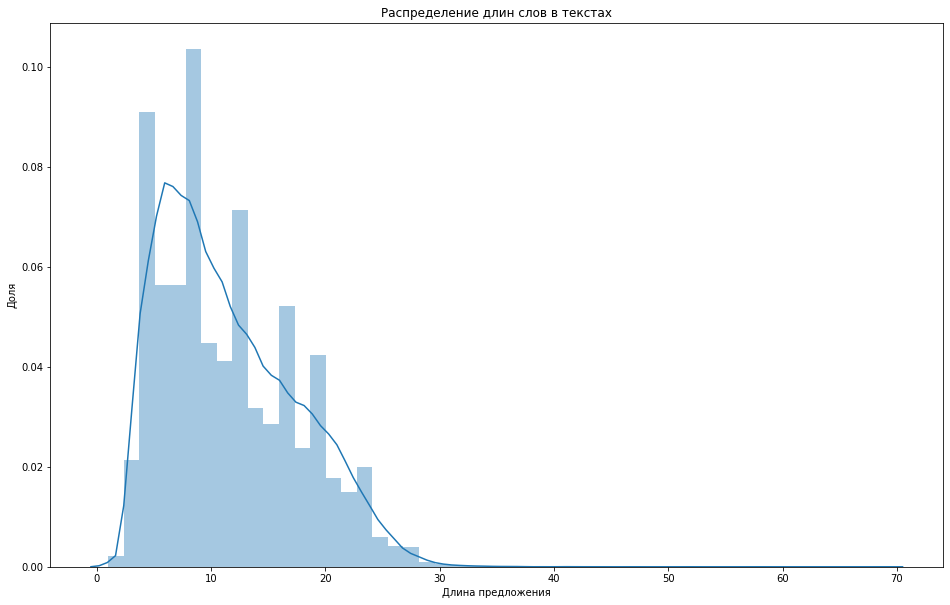

In [14]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [15]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.66 % наших текстов входят в промежуток от 3 до 32 слов'

In [16]:
len(word2freq)

152179

In [17]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'114332 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [18]:
import numpy as np

In [19]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [00:47<00:00, 42488.26it/s]


In [20]:
len(word2index)

117619

In [21]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 2.50 % слов в датасете
Количество неизвестных слов 34561 из 152179, то есть 22.71 % уникальных слов в словаре
В среднем каждое встречается 1.98 раз

Топ 5 невошедших слов:
??? с количеством вхождениий - 3641
?? с количеством вхождениий - 2448
!!! с количеством вхождениий - 2214
?) с количеством вхождениий - 2069
"? с количеством вхождениий - 1429


# Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой, но советую не заигрываться. Оценивается другое.

In [22]:
import torch

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [23]:
x = torch.rand(128, 64, 1024)

In [24]:
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

In [25]:
y, (hn, cn) = lstm(x)
y.shape, hn.shape, cn.shape

(torch.Size([128, 64, 512]),
 torch.Size([1, 128, 512]),
 torch.Size([1, 128, 512]))

# А что GPU?

In [26]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
print('Если недоступна, поменяйте runtime, если в колабе')

Доступна ли видеокарта: True
Если недоступна, поменяйте runtime, если в колабе


In [27]:
# универсальных способ задать device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# если доступна gpu, то давайте ее использовать, но в этом задании должны использовать

In [28]:
# перенесли x на gpu
x_gpu = x.to(device)

In [29]:
# зададим lstm на gpu
lstm_gpu = torch.nn.LSTM(1024, 512, batch_first=True)
lstm_gpu = lstm_gpu.to(device)

# У меня на 1070 TI скорость уменьшилась с 381мс до 41мс, то есть в 9.29 раз

In [30]:
# если у нас модель на гпу, а то, что мы туда подаем нет, то работать не будет
# справедлива и обратная ситуация

# выскочит ошибка
# посмотрите на нее, возможно, вы еще встретитесь
# pred = lstm_gpu(x)

# Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [31]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

pred, mem = lstm(x)

In [32]:
pred.shape

torch.Size([128, 64, 512])

In [33]:
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [34]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

torch.Size([64, 128, 512])

In [35]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

torch.Size([128, 64, 512])

## Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [36]:
x.shape

torch.Size([128, 64, 1024])

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [37]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [38]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [39]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

torch.Size([128, 1024, 64])

In [40]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

torch.Size([128, 512, 62])

In [41]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

torch.Size([128, 62, 512])

# Еще важный момент про LSTM

The input can also be a packed variable length sequence. See [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) or [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) for details.

Это внутренняя конструкция торча, которая позволяет не читать токен ```PAD```, но все еще работать с батчами. То есть внутри батча мы можем передать лстмке, что у нас данные переменной длины. Не забудьте что на выход отдается [torch.nn.utils.rnn.PackedSequence](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence).

# Подготовим данные в DataLoader

In [42]:
from torch.utils.data import Dataset, DataLoader

In [43]:
'UNK' in word2index

False

In [44]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


# Замапим категории в индексы

In [45]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [46]:
cat_mapper

{'business': 0, 'law': 1, 'love': 2, 'relax': 3, 'food': 4}

In [47]:
data.category = data.category.map(cat_mapper)

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.
    
## Что нужно сделать здесь
1. Дописать индексатор текста
1. Дописать паддинг текста
1. __*Опционально:*__ добавить что-то в предобработку

In [48]:
from typing import List

In [49]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = []
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, y_data, verbose=verbose)
        
    @staticmethod
    def process_text(text: str):
        
        # Место для вашей предобработки
    
        words = wordpunct_tokenize(text.lower())

        return words
        
    def load(self, data, y_data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text, y in zip(data_iterator, y_data):
            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            
            if indexed_words:
                self.x_data.append(indexed_words)
                self.y_data.append(y)
    
    def indexing(self, tokenized_text: List[str]) -> List[int]:

        # здесь мы не используем токен UNK, потому что мы мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        ### CODE ###
        
        return [self.word2index[token] for token in tokenized_text
                if token in self.word2index]
    
    def padding(self, sequence: List[int]) -> List[int]:
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        
        ### CODE ###
        
        sequence = sequence[:self.sequence_length]
        if len(sequence) < self.sequence_length:
            sequence += [self.pad_index] * (self.sequence_length - len(sequence))

        return sequence
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [50]:
dataset = WordData(data.text, data.category, word2index)

Loading data: 100%|██████████| 237779/237779 [00:01<00:00, 138661.48it/s]


In [51]:
data_loader = DataLoader(dataset, batch_size=64)

In [52]:
for x, y in data_loader:
    break

In [53]:
x

tensor([[  153,   137,     4,  ...,     0,     0,     0],
        [   65,   137, 97522,  ...,     0,     0,     0],
        [ 1584,   955,    17,  ...,     0,     0,     0],
        ...,
        [75752,   137,  8345,  ...,     0,     0,     0],
        [33902,  1327,     0,  ...,     0,     0,     0],
        [  172,  5175,  1015,  ...,     0,     0,     0]])

In [54]:
y

tensor([0, 1, 0, 0, 1, 0, 0, 2, 1, 3, 0, 0, 4, 1, 2, 4, 4, 4, 1, 0, 3, 3, 1, 1,
        1, 2, 1, 1, 4, 2, 0, 1, 1, 4, 3, 4, 1, 4, 4, 3, 1, 1, 4, 1, 3, 3, 4, 4,
        1, 1, 1, 0, 1, 3, 0, 1, 2, 2, 4, 0, 4, 4, 0, 3])

# Ожидается примерно следующее
```python
tensor([[  153,   137,     4,  ...,     0,     0,     0],
        [   65,   137, 97522,  ...,     0,     0,     0],
        [ 1584,   955,    17,  ...,     0,     0,     0],
        ...,
        [75752,   137,  8345,  ...,     0,     0,     0],
        [33902,  1327,     0,  ...,     0,     0,     0],
        [  172,  5175,  1015,  ...,     0,     0,     0]])
tensor([0, 1, 0, 0, 1, 0, 0, 2, 1, 3, 0, 0, 4, 1, 2, 4, 4, 4, 1, 0, 3, 3, 1, 1,
        1, 2, 1, 1, 4, 2, 0, 1, 1, 4, 3, 4, 1, 4, 4, 3, 1, 1, 4, 1, 3, 3, 4, 4,
        1, 1, 1, 0, 1, 3, 0, 1, 2, 2, 4, 0, 4, 4, 0, 3])
```

# Обучить нейронку

## План
1. Разбить датасет на трейн/тест или на трейн/валидация/тест, как вам больше нравится
1. Сделать класс нейронки, вписать необходимые операции, базовая архитектура ниже
1. Написать обучалку
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Отрисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__
1. Улучшить результат. Например, можно добавить BatchNorm, Dropout, Residual, etc __1 балл__
1. Сделать макро f1 больше 0.8 __1 балл__
1. Написать какие действия к чему приводили (почему вы их делали и оправдались ли ожидания)

## Базовая архитектура
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __1 балл__
1. Bidirectional LSTM. __1 балл__
2. Несколько параллельных CNN с разными размерами окна и пулингами к ним. __2 балла__
3. Конкатенация результатов CNN. __0 баллов__ (идет вместе с предыдущим пунктом)
4. Предикт в количество классов. __0 баллов__ (ну все-таки предсказать классы нужно обязательно)

__Дополнительные баллы:__
- Написать GRU с нуля самому __1 балл__
- Побить макро f1 0.84 __1 балл__
- Переобучиться и снизить переобучение за счет трюков. Пояснение: показываете, что вот такая архитектура переобучается, а вот я добавил/а это и это, изменил/а это и это и переобучение ушло __1 балл__
- Добавить селф аттеншин (написанный своими руками) __3 балла__
- За мультихед селф аттеншин еще __1 балл__
- Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
- Добавить дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
- Добавить шедуллеры __1 балл__
- your madness

### TIPs:
- Если будете брать ```train_test_split```, не забудьте сделать ```reset_index```, чтобы по индексу корректно доставались таргеты из ```y_data```  
- Необязательно делить датасет именно на 70 % и 30 %  
- Пулинг можно делать без торчового слоя

# РАЗМЕР ТЕСТА НЕ МЕНЬШЕ 10% ДАТАСЕТА
# 10 БАЛЛОВ МАКСИМУМ

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(list(data.text), list(data.category), test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.11, random_state=57)

In [57]:
train_dataset = WordData(X_train, y_train, word2index)
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Loading data: 100%|██████████| 190460/190460 [00:01<00:00, 127628.73it/s]


In [58]:
valid_dataset = WordData(X_valid, y_valid, word2index)
valid_data_loader = DataLoader(valid_dataset, batch_size=64)

Loading data: 100%|██████████| 23541/23541 [00:00<00:00, 150759.94it/s]


In [59]:
test_dataset = WordData(X_test, y_test, word2index)
test_data_loader = DataLoader(test_dataset, batch_size=64)

Loading data: 100%|██████████| 23778/23778 [00:00<00:00, 147234.18it/s]


In [64]:
import torch.nn.functional as F

In [65]:
class Model(torch.nn.Module):
    
    def __init__(self, input_size, emb_vectors, hidden_size=512, n_filters=64,
                 filter_sizes=(2,3,4), out_features=5):
        super().__init__()        
        
        self.emb = torch.nn.Embedding.from_pretrained(emb_vectors)
        self.lstm_dropout = torch.nn.Dropout(p=0.2)
        self.lstm = torch.nn.LSTM(input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.convs = torch.nn.ModuleList([
                                    torch.nn.Conv1d(in_channels = hidden_size*2, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) for fs in filter_sizes])
        
        self.lin = torch.nn.Linear(in_features=len(filter_sizes) * n_filters,
                                  out_features=out_features)
#         self.cnn_dropout = torch.nn.AlphaDropout(p=0.2)
    
    def forward(self, x):
        sent_lengths = x.bool().sum(dim=1)
        emb = self.emb(x)
        drop_emb = self.lstm_dropout(emb)
        packed = torch.nn.utils.rnn.pack_padded_sequence(drop_emb, sent_lengths, batch_first=True, enforce_sorted=False)
        lstm_emb, mem = self.lstm(packed)
        unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_emb, batch_first=True, total_length=32)
        conved = [F.relu(conv(unpacked.transpose(1, 2))) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = torch.cat(pooled, dim = 1)
        return self.lin(cat)

In [99]:
model = Model(300, torch.Tensor(vectors))
model.to(device)

Model(
  (emb): Embedding(117619, 300)
  (lstm_dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv1d(1024, 64, kernel_size=(2,), stride=(1,))
    (1): Conv1d(1024, 64, kernel_size=(3,), stride=(1,))
    (2): Conv1d(1024, 64, kernel_size=(4,), stride=(1,))
  )
  (lin): Linear(in_features=192, out_features=5, bias=True)
)

In [100]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

In [101]:
from sklearn.metrics import f1_score
import datetime
import time

In [102]:
def calculate_metrics(model: torch.nn.Module, data_loader, loss_function, extended=False):
    train_state = model.training
    
    with torch.no_grad():
        model.eval()
        start_time = time.time()
        y_golds, y_preds, losses = [], [], []
        for x, y in data_loader:
            y_pred = model(x.to(device))
            losses.append(loss_function(y_pred, y.to(device)).item())
            
            y_pred = torch.argmax(y_pred, dim=1).cpu()
            y_golds.extend(y.numpy())
            y_preds.extend(y_pred.numpy())
        y_golds = np.asarray(y_golds)
        y_preds = np.asarray(y_preds)
        
    model.train(train_state)
    
    metrics = {
        'f1_macro': f1_score(y_golds, y_preds, labels=list(range(5)), average='macro'),
        'acc': np.mean(y_golds == y_preds),
        'loss': np.mean(losses),
        'time_spent': str(datetime.timedelta(seconds=time.time() - start_time))
    }
    if extended:
        metrics['confusion_matrix'] = confusion_matrix(y_golds, y_preds)
    return metrics

In [103]:
import sys

save_path = './model.pt'
saved = False

n_epoch = 0

best_f1 = 0
max_patience = 3
patience = 0

losses = []
valid_metrics = []

model.train()

while True:

    try:

        with tqdm(total=len(train_data_loader.dataset), desc='Epoch {}'.format(n_epoch + 1)) as progress_bar:

            for x, y in train_data_loader:

                # CODE

                optimizer.zero_grad()

                y_pred = model(x.to(device))

                loss = criterion(y_pred, y.to(device))
                loss.backward()
                optimizer.step()

                # CODE

                losses.append(loss.item())

                progress_bar.set_postfix(loss=np.mean(losses[-500:]))

                progress_bar.update(x.shape[0])

        ###### VALIDATION ########
        metrics = calculate_metrics(model, valid_data_loader, criterion)
        valid_metrics.append(metrics)
        print('VALID:', metrics, file=sys.stderr)
        if metrics['f1_macro'] > best_f1:
            best_f1 = metrics['f1_macro']
            patience = 0
            torch.save(model.state_dict(), save_path)
            saved = True
        else:
            patience += 1
            
        if patience >= max_patience:
            print('STOPPED EARLY', file=sys.stderr)
            break
            
        n_epoch += 1

    except KeyboardInterrupt:
        print('INTERRUPTED', file=sys.stderr)
        break

if saved:
    model.load_state_dict(torch.load(save_path))  # load best model
model.eval()  # for inference

print('VALID:', calculate_metrics(model, valid_data_loader, criterion), file=sys.stderr)
print('TEST:', calculate_metrics(model, test_data_loader, criterion), file=sys.stderr)

Epoch 1: 100%|██████████| 190425/190425 [02:08<00:00, 1486.08it/s, loss=0.495]
VALID: {'f1_macro': 0.8263533482947765, 'acc': 0.8306849082256968, 'loss': 0.46591697442952706, 'time_spent': '0:00:04.329843'}
Epoch 2: 100%|██████████| 190425/190425 [02:08<00:00, 1487.59it/s, loss=0.463]
VALID: {'f1_macro': 0.8402209060630919, 'acc': 0.8433463630183549, 'loss': 0.43739519041517505, 'time_spent': '0:00:04.138660'}
Epoch 3: 100%|██████████| 190425/190425 [02:08<00:00, 1478.54it/s, loss=0.433]
VALID: {'f1_macro': 0.8398449016534073, 'acc': 0.8437287559483345, 'loss': 0.4332092456600588, 'time_spent': '0:00:04.135930'}
Epoch 4: 100%|██████████| 190425/190425 [02:09<00:00, 1475.49it/s, loss=0.409]
VALID: {'f1_macro': 0.845016280159815, 'acc': 0.8474252209381373, 'loss': 0.42511825546946214, 'time_spent': '0:00:04.143185'}
Epoch 5: 100%|██████████| 190425/190425 [02:08<00:00, 1478.70it/s, loss=0.387]
VALID: {'f1_macro': 0.8406211494758411, 'acc': 0.8458956492182189, 'loss': 0.425078258930665, '

In [104]:
print('TRAIN:', calculate_metrics(model, train_data_loader, criterion), file=sys.stderr)

TRAIN: {'f1_macro': 0.8931032289009788, 'acc': 0.8941893133779704, 'loss': 0.2922937422715408, 'time_spent': '0:00:33.651954'}


In [105]:
valid_losses = [item['loss'] for item in valid_metrics]
valid_f1 = [item['f1_macro'] for item in valid_metrics]

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

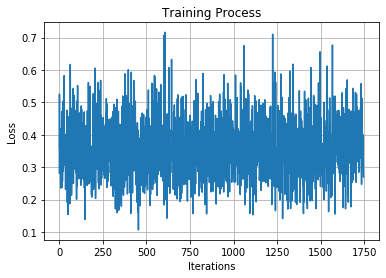

In [107]:
plt.title('Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(train_losses)

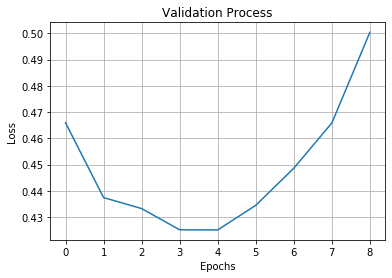

In [108]:
plt.title('Validation Process')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(valid_losses)

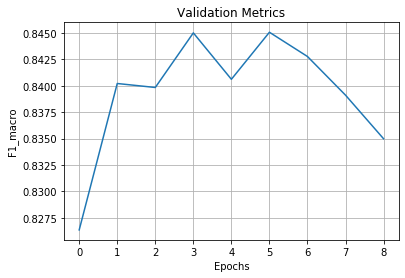

In [109]:
plt.title('Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('F1_macro')
plt.grid()
plt.plot(valid_f1)

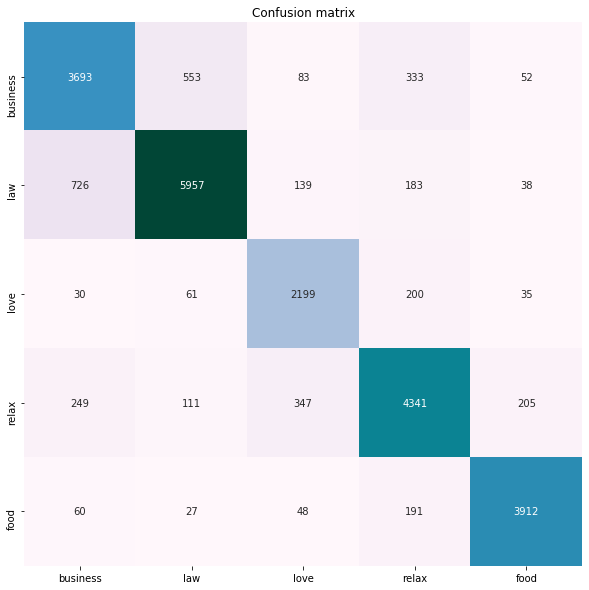

In [110]:
test_metrics = calculate_metrics(model, test_data_loader, criterion, extended=True)
m = test_metrics['confusion_matrix']
labels = ['business', 'law', 'love', 'relax', 'food']
plt.figure(figsize = (10,10))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap="PuBuGn")
plt.title("Confusion matrix")
plt.show()

# Итого сделано:

1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__
    1. Каждую эпоху рассчитывать метрики __0.25 балла__
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__
1. Добавить early stopping __0.5 балла__
1. Отрисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__
1. Улучшить результат. Например, можно добавить BatchNorm, Dropout, Residual, etc __1 балл__
1. Сделать макро f1 больше 0.8 __1 балл__
1. Написать какие действия к чему приводили (почему вы их делали и оправдались ли ожидания):
  - добавлен дропаут = 0.2 перед lstm => стало меньше переобучаться
  - зашафлен трейн сет на каждой эпохе => метрики стали повыше
  - альфа-дропаут = 0.2 перед свертками => замедлил обучение и не помог с переобучением
  - несколько параллельных сверток вместо одной повышают метрики

## Базовая архитектура
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __1 балл__
1. Bidirectional LSTM. __1 балл__
2. Несколько параллельных CNN с разными размерами окна и пулингами к ним. __2 балла__
3. Конкатенация результатов CNN. __0 баллов__ (идет вместе с предыдущим пунктом)
4. Предикт в количество классов. __0 баллов__ (ну все-таки предсказать классы нужно обязательно)

__Дополнительные баллы:__
- Побить макро f1 0.84 __1 балл__
- Переобучиться и снизить переобучение за счет трюков. Пояснение: показываете, что вот такая архитектура переобучается, а вот я добавил/а это и это, изменил/а это и это и переобучение ушло __1 балл__
- Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__
- Добавить дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__